Spectrogram saved to phonetic_spectrogram.png


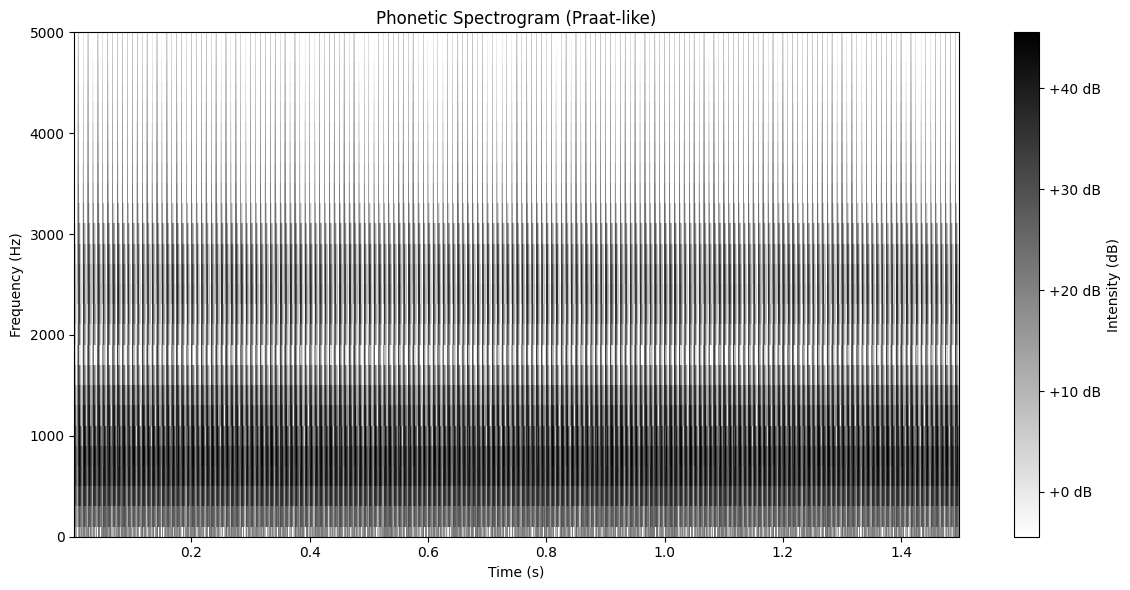

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram as scipy_spectrogram, windows, lfilter

def praat_like_spectrogram(
    audio_path,
    output_path=None,
    view_range_hz=(0, 5000),
    window_length_s=0.005,
    dynamic_range_db=50,
    pre_emphasis_from_hz=50
):
    """
    Generates and optionally saves a spectrogram with settings
    designed to mimic Praat's defaults for phonetic analysis.

    Args:
        audio_path (str): Path to the WAV audio file.
        output_path (str, optional): Path to save the spectrogram image. If None, the plot is displayed.
        view_range_hz (tuple, optional): The frequency range (min, max) to display in Hz.
        window_length_s (float, optional): The length of the analysis window in seconds.
        dynamic_range_db (int, optional): The dynamic range in dB for the colormap.
        pre_emphasis_from_hz (int, optional): The frequency from which to apply pre-emphasis.
    """
    try:
        sample_rate, samples = wavfile.read(audio_path)

        if samples.ndim > 1:
            samples = samples.mean(axis=1)

        # --- 1. Pre-emphasis ---
        # Praat's "6 dB/octave" pre-emphasis is equivalent to a first-order high-pass filter.
        # The coefficient 'k' is typically between 0.95 and 0.98.
        # We can calculate it from the pre-emphasis frequency. [3]
        k = np.exp(-2 * np.pi * pre_emphasis_from_hz / sample_rate)
        emphasized_samples = lfilter([1, -k], 1, samples)

        # --- 2. Windowing Parameters ---
        nperseg = int(window_length_s * sample_rate)
        # Praat's default "time step" of 1000/sec means a hop length of sample_rate / 1000
        hop_length = int(sample_rate / 1000)
        noverlap = nperseg - hop_length

        # Use a Gaussian window, which is Praat's default.
        window = windows.gaussian(nperseg, std=nperseg / 8) # A standard deviation of 1/8 of the window is a common choice

        # --- 3. Spectrogram Calculation ---
        frequencies, times, Sxx = scipy_spectrogram(
            emphasized_samples,
            fs=sample_rate,
            window=window,
            nperseg=nperseg,
            noverlap=noverlap,
            scaling='density'
        )

        # --- 4. Power and Dynamic Range ---
        Sxx_db = 10 * np.log10(np.maximum(Sxx, 1e-10))
        max_db = np.max(Sxx_db)
        min_db = max_db - dynamic_range_db # Apply the dynamic range

        # --- 5. Plotting ---
        plt.figure(figsize=(12, 6))
        plt.pcolormesh(
            times,
            frequencies,
            Sxx_db,
            cmap='gray_r', # Use reversed grayscale for dark formants on a light background
            vmin=min_db,
            vmax=max_db,
            shading='auto'
        )

        plt.ylim(view_range_hz)
        plt.xlabel("Time (s)")
        plt.ylabel("Frequency (Hz)")
        plt.title("Phonetic Spectrogram (Praat-like)")

        cbar = plt.colorbar(format='%+2.0f dB')
        cbar.set_label('Intensity (dB)')

        plt.tight_layout()

        if output_path:
            plt.savefig(output_path, dpi=300)
            print(f"Spectrogram saved to {output_path}")
        else:
            plt.show()

    except FileNotFoundError:
        print(f"Error: The file at {audio_path} was not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# --- Example Usage with a Synthesized Vowel Sound ---
# This creates a more realistic speech-like sound with harmonics and formants
from scipy.io.wavfile import write

sr = 22050  # Sample rate
duration = 1.5  # seconds
f0 = 120  # Fundamental frequency (pitch)
t = np.linspace(0., duration, int(sr * duration))

# Create a harmonic series (source)
harmonics = np.zeros_like(t)
for i in range(1, int(sr / (2 * f0))):
    harmonics += (1 / i) * np.sin(2 * np.pi * f0 * i * t)

# Create a filter (vocal tract) with three formants for an "ah"-like vowel
def formant_filter(x, F1, F2, F3):
    from scipy.signal import butter, lfilter
    nyquist = 0.5 * sr
    # Formant 1
    b, a = butter(2, [F1-100, F1+100], btype='bandpass', fs=sr)
    y1 = lfilter(b, a, x)
    # Formant 2
    b, a = butter(2, [F2-150, F2+150], btype='bandpass', fs=sr)
    y2 = lfilter(b, a, x)
    # Formant 3
    b, a = butter(2, [F3-200, F3+200], btype='bandpass', fs=sr)
    y3 = lfilter(b, a, x)
    return (y1 + y2*0.6 + y3*0.3)

filtered_sound = formant_filter(harmonics, F1=730, F2=1090, F3=2440)

# Normalize and write to WAV file
scaled_sound = np.int16(filtered_sound / np.max(np.abs(filtered_sound)) * 32767)
wav_path = "vowel_ah.wav"
write(wav_path, sr, scaled_sound)

# Generate the Praat-like spectrogram from the synthesized vowel
praat_like_spectrogram(wav_path, output_path="phonetic_spectrogram.png")